## GeoParquet konverteringsbibliotek
Bibliotek for å identifisere, konvertere og administrere geografiske datafiler.
Støtter konvertering av ulike geografiske formater (.parquet, .geojson, .shp, .gpkg, .csv) til GeoParquet-format.

In [1]:
pip install -r requirements.txt


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /usr/local/bin/python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### 1. Importering

In [2]:
import os
import pyarrow.parquet as pq
import geopandas as gpd
import pandas as pd
import datetime
import json
from shapely import wkt

### 2. Verifisering

In [3]:
def sjekk_metadata_inneholder_geo(schema):
    """Sjekker om parquet-skjemaet inneholder geo-metadata i noen kolonner"""
    for navn in schema.names:
        felt = schema.field(navn)
        if felt.metadata and ('geo' in felt.metadata or b'geo' in felt.metadata):
            return True
    return False

def sjekk_inneholder_geometrikolonne(filsti):
    """Sjekker om filen inneholder en geometrikolonne ved å lese den med geopandas"""
    gdf = gpd.read_parquet(filsti)
    return hasattr(gdf, 'geometry') and gdf.geometry.name in gdf.columns

def er_geoparquet(filsti):
    """Sjekker om en parquet-fil er en GeoParquet-fil ved å undersøke metadata og innhold"""
    # Hvis filen ikke kan leses som parquet, er den ikke en geoparquet
    try:
        schema = pq.read_schema(filsti)
    except:
        return False

    # Sjekk metadata
    if sjekk_metadata_inneholder_geo(schema):
        return True

    # Sjekk geometrikolonne i geopandas
    try:
        return sjekk_inneholder_geometrikolonne(filsti)
    except:
        return False

### 3. Filhåndtering

In [4]:
def lag_målfilsti(kildefilsti, målmappesti=None):
    """Lager målfilsti basert på kildesti og evt. målmappe"""
    base_navn = os.path.basename(kildefilsti)
    base_navn_uten_endelse = os.path.splitext(base_navn)[0]

    if målmappesti is None:
        # Hvis ingen målmappe er angitt, bruk samme mappe med _geo.parquet
        dir_navn = os.path.dirname(kildefilsti)
        return os.path.join(dir_navn, f"{base_navn_uten_endelse}_geo.parquet")
    else:
        # Hvis målmappe er angitt, plasser filen der
        return os.path.join(målmappesti, f"{base_navn_uten_endelse}.parquet")

def opprett_mappe(filsti):
    """Sørger for at mappen for filstien eksisterer"""
    os.makedirs(os.path.dirname(filsti), exist_ok=True)

def opprett_mappestruktur(rotmappe):
    """Opprettermappestrukturen"""
    mapper = [
        os.path.join(rotmappe, 'raw'),
        os.path.join(rotmappe, 'processed'),
        os.path.join(rotmappe, 'archive')
    ]

    for mappe in mapper:
        os.makedirs(mappe, exist_ok=True)

    return {
        'raw': mapper[0],
        'processed': mapper[1],
        'archive': mapper[2]
    }

### 4. Konvertering

In [5]:
def konverter_parquet(filsti):
    """Konverterer parquet-fil til GeoDataFrame"""
    df = pd.read_parquet(filsti)

    # Sjekk etter lat/long kolonner
    if 'longitude' in df.columns and 'latitude' in df.columns:
        return gpd.GeoDataFrame(
            df,
            geometry=gpd.points_from_xy(df.longitude, df.latitude),
            crs="EPSG:4326"
        )

    # Sjekk etter potensielle geometrikolonner
    geom_kolonner = [col for col in df.columns if 'geom' in col.lower()
                   or 'coord' in col.lower()
                   or 'point' in col.lower()
                   or 'polygon' in col.lower()
                   or 'linestring' in col.lower()
                   or 'wkt' in col.lower()]

    for col in geom_kolonner:
        if df[col].dtype == 'object':
            try:
                # Prøv å konvertere fra WKT-format
                geom = df[col].apply(wkt.loads)
                return gpd.GeoDataFrame(df, geometry=geom, crs="EPSG:4326")
            except:
                continue

    return None

def konverter_csv(filsti):
    """Konverterer CSV-fil til GeoDataFrame"""
    df = pd.read_csv(filsti)

    # Sjekk for vanlige lat/long kolonnenavn
    lat_kolonner = ['latitude', 'lat', 'y', 'breddegrad']
    lon_kolonner = ['longitude', 'long', 'lon', 'x', 'lengdegrad']

    lat_col = next((col for col in lat_kolonner if col in df.columns), None)
    lon_col = next((col for col in lon_kolonner if col in df.columns), None)

    if lat_col and lon_col:
        return gpd.GeoDataFrame(
            df,
            geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
            crs="EPSG:4326"
        )

    return None

def konverter_fil_basert_på_type(filsti, filendelse):
    """Konverterer fil til GeoDataFrame basert på filendelse"""
    if filendelse == '.parquet':
        return konverter_parquet(filsti)

    elif filendelse in ['.geojson', '.json', '.shp', '.gpkg']:
        return gpd.read_file(filsti)

    elif filendelse == '.gml':
        # Bruk fiona for å liste opp alle lag
        import fiona
        try:
            layers = fiona.listlayers(filsti)
            if layers:
                print(f"GML-fil har {len(layers)} lag: {', '.join(layers)}")
                # Les det første laget, som er standard
                return gpd.read_file(filsti, layer=layers[0])
            else:
                return gpd.read_file(filsti)
        except Exception as e:
            print(f"Kunne ikke lese GML-lag: {e}")
            # Prøv vanlig lesing hvis lagdeteksjon feiler
            return gpd.read_file(filsti)

    elif filendelse == '.csv':
        return konverter_csv(filsti)

    return None

def konverter_til_geoparquet(kildefilsti, målmappesti=None):
    """Konverterer ulike geografiske formater til GeoParquet-format"""
    # Få filendelse
    filendelse = os.path.splitext(kildefilsti)[1].lower()

    # Bestem målfilsti
    målfilsti = lag_målfilsti(kildefilsti, målmappesti)

    # Sørg for at målmappen eksisterer
    opprett_mappe(målfilsti)

    try:
        # Konverter filen basert på filtype
        gdf = konverter_fil_basert_på_type(kildefilsti, filendelse)

        # Hvis vi har en gyldig geodataframe, lagre som GeoParquet
        if gdf is not None:
            gdf.to_parquet(målfilsti)
            return målfilsti
    except Exception as e:
        print(f"Feil ved konvertering av {kildefilsti}: {e}")

    return False

### 5. Logging

In [6]:
def les_eksisterende_logg(konverteringslogg_sti):
    """Leser inn eksisterende konverteringslogg"""
    if not os.path.exists(konverteringslogg_sti):
        return {}

    try:
        with open(konverteringslogg_sti, 'r') as f:
            return json.load(f)
    except:
        return {}

def lag_logginnslag(fil, målfilsti):
    """Lager et nytt logginnslag for en konvertert fil"""
    base_navn = os.path.splitext(os.path.basename(fil))[0]
    nå = datetime.datetime.now()

    return {
        base_navn: {
            'kildesti': fil,
            'målsti': målfilsti,
            'tidspunkt': nå.timestamp(),
            'dato': nå.strftime('%Y-%m-%d %H:%M:%S')
        }
    }

def lagre_logg(konverteringslogg_sti, loggdata):
    """Lagrer konverteringslogg til fil"""
    with open(konverteringslogg_sti, 'w') as f:
        json.dump(loggdata, f, indent=2)

def oppdater_konverteringslogg(konverteringslogg_sti, fil, målfilsti):
    """Oppdaterer konverteringsloggen med ny filinfo"""
    # Last inn eksisterende logg
    konverterte_logger = les_eksisterende_logg(konverteringslogg_sti)

    # Lag og legg til nytt logginnslag
    nytt_innslag = lag_logginnslag(fil, målfilsti)
    konverterte_logger.update(nytt_innslag)

    # Lagre oppdatert logg
    lagre_logg(konverteringslogg_sti, konverterte_logger)

### 6. Feilsøking

In [16]:
def hent_støttede_formater():
    """Returnerer liste over støttede filformater"""
    return ['.parquet', '.geojson', '.json', '.shp', '.gpkg', '.csv', '.gml']

def hent_konverterte_filer(prosessert_mappesti):
    """Henter ut alle allerede konverterte filer"""
    konverterte_filer = set()
    if not os.path.exists(prosessert_mappesti):
        return konverterte_filer

    for root, _, filer in os.walk(prosessert_mappesti):
        for fil in filer:
            if fil.endswith('.parquet'):
                base_navn = os.path.splitext(fil)[0]
                konverterte_filer.add(base_navn)

    return konverterte_filer

def er_fil_gyldig_for_konvertering(filsti, base_navn, filendelse, støttede_formater):
    """Sjekker om en fil er gyldig for konvertering"""
    # Ikke konverter loggfiler
    if base_navn == "conversion_log" or filsti.endswith("conversion_log.json"):
        return False

    # Sjekk om filen har et støttet format
    if filendelse not in støttede_formater:
        return False

    # Parquet-filer trenger ekstra sjekk
    if filendelse == '.parquet':
        # Ikke ta med filer som allerede er GeoParquet
        if er_geoparquet(filsti):
            return False
        # Ikke ta med filer som allerede har _geo suffix
        if base_navn.endswith('_geo'):
            return False

    return True

def trenger_fil_konvertering(filsti, base_navn, konverterte_filer, konverterte_logger):
    """Sjekker om en fil trenger konvertering basert på konverteringshistorikk"""
    # Sjekk loggfilen
    if base_navn in konverterte_logger:
        # Sjekk om den konverterte filen faktisk eksisterer
        hvis_målsti = konverterte_logger[base_navn].get('målsti', None)
        if hvis_målsti and os.path.exists(hvis_målsti):
            # Filen finnes - sjekk om den har blitt endret siden sist konvertering
            sist_endret_tid = os.path.getmtime(filsti)
            sist_konvertert_tid = konverterte_logger[base_navn].get('tidspunkt', 0)
            if sist_endret_tid <= sist_konvertert_tid:
                return False
        else:
            # Filen i loggfilen eksisterer ikke - den bør konverteres på nytt
            print(f"Konvertert fil {hvis_målsti} finnes ikke, konverterer på nytt...")
            return True

    # Sjekk om filen allerede finnes i processed-mappen
    return base_navn not in konverterte_filer

def finn_nye_filer(rå_mappesti, prosessert_mappesti, konverteringslogg_sti=None):
    """Finner filer som ikke har blitt konvertert ennå"""
    støttede_formater = hent_støttede_formater()
    konverterte_filer = hent_konverterte_filer(prosessert_mappesti)
    konverterte_logger = les_eksisterende_logg(konverteringslogg_sti)

    nye_filer = []

    for root, _, filer in os.walk(rå_mappesti):
        for fil in filer:
            filsti = os.path.join(root, fil)
            filendelse = os.path.splitext(fil)[1].lower()
            base_navn = os.path.splitext(fil)[0]

            # Sjekk om filen er gyldig for konvertering
            if not er_fil_gyldig_for_konvertering(filsti, base_navn, filendelse, støttede_formater):
                continue

            # Sjekk om filen trenger konvertering
            if trenger_fil_konvertering(filsti, base_navn, konverterte_filer, konverterte_logger):
                nye_filer.append(filsti)

    return nye_filer

### 7. Hovedfunksjoner

In [8]:
def valider_rotmappe(rotmappesti):
    """Validerer at rotmappen eksisterer, og oppretter den hvis mulig"""
    if os.path.exists(rotmappesti):
        return True

    try:
        # Prøv å opprette mappen
        os.makedirs(rotmappesti, exist_ok=True)
        print(f"Opprettet mappe: {rotmappesti}")
        return True
    except Exception as e:
        print(f"FEIL: Kunne ikke opprette katalogen '{rotmappesti}': {e}")
        return False

def oppsett_mappestier(rotmappesti, opprett_struktur):
    """Setter opp og returnerer nødvendige mappestier"""
    mappestruktur = None
    rå_mappesti = rotmappesti
    prosessert_mappesti = rotmappesti

    # Opprett mappestruktur hvis ønsket
    if opprett_struktur:
        try:
            mappestruktur = opprett_mappestruktur(rotmappesti)
            rå_mappesti = mappestruktur['raw']
            prosessert_mappesti = mappestruktur['processed']
            print(f"Opprettet mappestruktur:\n- Raw: {rå_mappesti}\n- Processed: {prosessert_mappesti}")
        except Exception as e:
            print(f"ADVARSEL: Kunne ikke opprette fullstendig mappestruktur: {e}")
            print("Fortsetter med standardmapper...")

    return {
        "mappestruktur": mappestruktur,
        "rå_mappesti": rå_mappesti,
        "prosessert_mappesti": prosessert_mappesti,
        "konverteringslogg_sti": os.path.join(rotmappesti, 'conversion_log.json')
    }

def konverter_filer(nye_filer, prosessert_mappesti, konverteringslogg_sti):
    """Konverterer filer og oppdaterer logg"""
    resultater = {
        "konvertert": [],
        "feilet": []
    }

    for filsti in nye_filer:
        # Konverter filen
        målfilsti = konverter_til_geoparquet(filsti, prosessert_mappesti)

        if målfilsti:
            resultater["konvertert"].append(filsti)
            oppdater_konverteringslogg(konverteringslogg_sti, filsti, målfilsti)
        else:
            resultater["feilet"].append(filsti)

    return resultater

def finn_eksisterende_geoparquet(rå_mappesti, alle_filer):
    """Finner eksisterende GeoParquet-filer"""
    allerede_geoparquet = []

    for root, _, filer in os.walk(rå_mappesti):
        for fil in filer:
            if fil.endswith('.parquet'):
                filsti = os.path.join(root, fil)
                if er_geoparquet(filsti) and filsti not in alle_filer:
                    allerede_geoparquet.append(filsti)

    return allerede_geoparquet

def skriv_oppsummering(rotmappesti, mappestier, resultater):
    """Skriver oppsummering av konverteringsprosessen"""
    print("\n")
    print("OPPSUMMERING")
    print(f"Katalog: {rotmappesti}")

    if mappestier["mappestruktur"]:
        print(f"Mappestruktur: Raw={mappestier['rå_mappesti']}, Processed={mappestier['prosessert_mappesti']}")

    totalt_antall = len(resultater["alle_filer"])
    antall_allerede_geo = len(resultater["allerede_geoparquet"])
    antall_konvertert = len(resultater["konvertert"])
    antall_feilet = len(resultater["feilet"])

    print(f"Totalt antall geografiske filer funnet: {totalt_antall}")
    print(f"Antall parquet-filer som allerede var GeoParquet: {antall_allerede_geo}")
    print(f"Antall filer konvertert til GeoParquet: {antall_konvertert}")
    print(f"Antall filer som ikke kunne konverteres: {antall_feilet}")

    if resultater["konvertert"]:
        print("\nKonverterte filer:")
        for fil in resultater["konvertert"]:
            print(f"- {fil}")

    if resultater["feilet"]:
        print("\nFiler som ikke kunne konverteres:")
        for fil in resultater["feilet"]:
            print(f"- {fil}")

def behandle_alle_filer_i_mappe(rotmappesti, opprett_struktur=True):
    """Behandler alle geografiske filer i angitt mappe og konverterer til GeoParquet."""
    # Validering og mappestruktur (gjør dette først!)
    if not valider_rotmappe(rotmappesti):
        print(f"Vennligst oppgi en gyldig mappe som du har tilgang til.")
        print(f"For eksempel: './data' (relativ sti) eller '~/data' (i hjemmekatalogen)")
        return None

    # Oppsett av mappestruktur
    mappestier = oppsett_mappestier(rotmappesti, opprett_struktur)

    # Uansett om opprett_struktur er True eller False, sørg for at processed-mappen eksisterer
    processed_sti = os.path.join(rotmappesti, 'processed')
    if not os.path.exists(processed_sti):
        try:
            os.makedirs(processed_sti, exist_ok=True)
            print(f"Opprettet processed-mappe: {processed_sti}")
        except Exception as e:
            print(f"FEIL: Kunne ikke opprette processed-mappen: {e}")

    # Bruk processed-sti som målmappe i stedet for prosessert_mappesti fra oppsett_mappestier
    if not os.path.exists(processed_sti):
        try:
            os.makedirs(processed_sti, exist_ok=True)
        except Exception as e:
            print(f"FEIL: Kunne ikke opprette målmappen '{processed_sti}': {e}")
            return None

    # Finn nye filer som trenger konvertering
    nye_filer = finn_nye_filer(
        mappestier["rå_mappesti"],
        processed_sti,  # Bruk den spesifikke processed-stien
        mappestier["konverteringslogg_sti"]
    )

    # Konverter filene og samle resultatene - bruk processed_sti som målmappe
    konverteringsresultater = konverter_filer(
        nye_filer,
        processed_sti,  # Bruk den spesifikke processed-stien
        mappestier["konverteringslogg_sti"]
    )

    # Finn eksisterende GeoParquet-filer
    allerede_geoparquet = finn_eksisterende_geoparquet(
        mappestier["rå_mappesti"],
        nye_filer
    )

    # Sammenstill resultater
    resultater = {
        "alle_filer": nye_filer,
        "konvertert": konverteringsresultater["konvertert"],
        "feilet": konverteringsresultater["feilet"],
        "allerede_geoparquet": allerede_geoparquet
    }

    # Skriv oppsummering - oppdater mappestier med correct processed_sti
    mappestier["prosessert_mappesti"] = processed_sti
    skriv_oppsummering(rotmappesti, mappestier, resultater)

    return resultater

In [9]:
# Opprett nødvendig mappestruktur
rotmappe = "./data"  # Relativ sti til prosjektets rotmappe

# Sjekk om mappen finnes, hvis ikke - lag den
if not os.path.exists(rotmappe):
    try:
        os.makedirs(rotmappe, exist_ok=True)
        print(f"Opprettet rotmappe: {rotmappe}")

        # Opprett undermappe-struktur
        mappestier = opprett_mappestruktur(rotmappe)
        print(f"Opprettet mappestruktur:")
        for navn, sti in mappestier.items():
            print(f"- {navn}: {sti}")
    except Exception as e:
        print(f"FEIL: Kunne ikke opprette nødvendig mappestruktur: {e}")
else:
    print(f"Mappen {rotmappe} finnes allerede")

Mappen ./data finnes allerede


### 8. Demo av bruk

In [14]:
# Definerer rotmappen
rotmappe = "./data"

# Sjekk at mappen eksisterer før vi fortsetter
if not os.path.exists(rotmappe):
    print(f"ADVARSEL: Mappen {rotmappe} finnes ikke ennå. Oppretter den...")
    os.makedirs(rotmappe, exist_ok=True)
    print(f"Opprettet mappe: {rotmappe}")

    # Opprett understrukturen med en gang
    mappestier = opprett_mappestruktur(rotmappe)

# Kjører konverteringsprosessen
resultater = behandle_alle_filer_i_mappe(rotmappe, opprett_struktur=False)

# Viser resultatet
if resultater:
    print(f"\nTotalt konverterte filer: {len(resultater['konvertert'])}")
    print(f"Filer som allerede var i GeoParquet-format: {len(resultater['allerede_geoparquet'])}")
else:
    print("Konverteringen feilet. Sjekk filtype og format!")




OPPSUMMERING
Katalog: ./data
Totalt antall geografiske filer funnet: 0
Antall parquet-filer som allerede var GeoParquet: 7
Antall filer konvertert til GeoParquet: 0
Antall filer som ikke kunne konverteres: 0

Totalt konverterte filer: 0
Filer som allerede var i GeoParquet-format: 7


### 9. Eksempel på bruksområde

Konverterer ./data/raw/veier_kristiansand.geojson...
Filen ble konvertert og lagret til: ./data/processed/veier_kristiansand.parquet


,id,@id,access,access:lanes,alt_name,area,bicycle,bridge,bridge:description,bridge:structure,...,tunnel:description,turn:lanes,turn:lanes:backward,turn:lanes:forward,undefined,unsigned_ref,width,wikidata,wikipedia,geometry
0,way/455890874,way/455890874,None,None,None,yes,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((8.08945 58.18284, 8.08943 58.18283, ..."
1,way/464102448,way/464102448,None,None,None,yes,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((8.09091 58.18265, 8.09111 58.18269, ..."
2,way/464104304,way/464104304,None,None,None,yes,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((8.08819 58.1902, 8.08812 58.1902, 8...."
3,way/509246312,way/509246312,None,None,None,yes,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((8.08721 58.18111, 8.0871 58.18114, 8..."
4,way/4363978,way/4363978,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (8.13914 58.18071, 8.1408 58.18061,..."


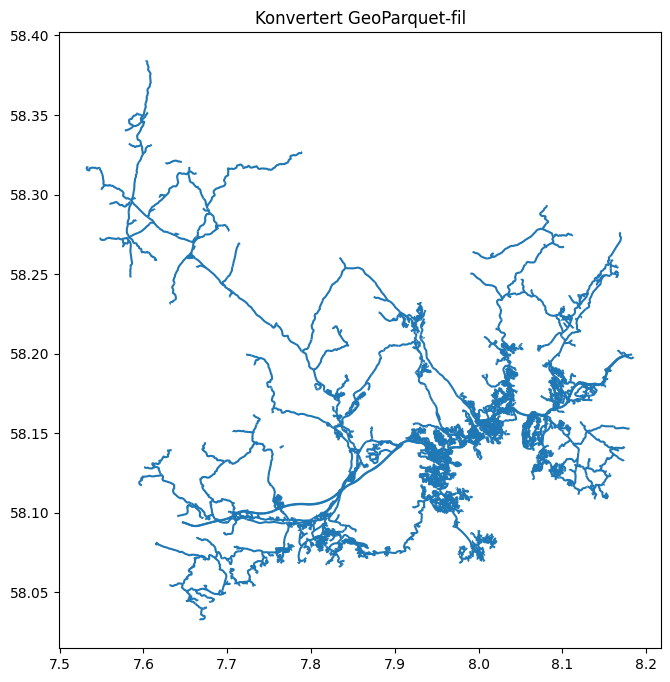

In [13]:
# ## Konvertere én enkelt fil - eksempel
rotmappe = "./data"

# Definerer stier basert på den opprettede mappestrukturen
if os.path.exists(rotmappe):
    rå_mappe = os.path.join(rotmappe, "raw")
    prosessert_mappe = os.path.join(rotmappe, "processed")

    # Eksempelfil - dette er for demonstrasjon,
    eksempelfil = os.path.join(rå_mappe, "veier_kristiansand.geojson")

    # Utfør kun hvis filen eksisterer (endre denne kommentaren hvis du har en faktisk fil)
    if os.path.exists(eksempelfil):
        print(f"Konverterer {eksempelfil}...")
        resultat = konverter_til_geoparquet(eksempelfil, prosessert_mappe)
        if resultat:
            print(f"Filen ble konvertert og lagret til: {resultat}")

            # Lese og vise data
            try:
                gdf = gpd.read_parquet(resultat)
                display(gdf.head())

                # Enkel kartvisning
                import matplotlib.pyplot as plt
                fig, ax = plt.subplots(figsize=(10,8))
                gdf.plot(ax=ax)
                plt.title("Konvertert GeoParquet-fil")
                plt.show()
            except Exception as e:
                print(f"Kunne ikke vise data: {e}")
    else:
        print(f"Ingen eksempelfil funnet på {eksempelfil}")
        print("For å teste konvertering:")
        print(f"1. Legg en geografisk fil (f.eks. GeoJSON eller Shapefile) i {rå_mappe}")
        print(f"2. Kjør denne cellen på nytt med korrekt filsti")
else:
    print(f"Rotmappe {rotmappe} finnes ikke. Kjør seksjon 8 først.")